In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(seed=1)

In [2]:
df = pd.read_excel('Newdata1.xlsx')

In [3]:
# Tokenizing text
# use texts_to_sequence to make each words to seq

from keras.preprocessing.text import Tokenizer
DEFAULT_VOCAB_SIZE = 1000

def create_tokenized_seq(series: pd.Series , vocab_size: int = DEFAULT_VOCAB_SIZE):
    tokenizer = Tokenizer(
        num_words=vocab_size,
        lower=True,
        oov_token="<OOV>",
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r')
    tokenizer.fit_on_texts(series.dropna().values)
    return tokenizer.texts_to_sequences(series.apply(lambda x: x if isinstance(x, str) else ''))


title_seq = create_tokenized_seq(df['title'])
desc_seq = create_tokenized_seq(df['description'])
req_seq = create_tokenized_seq(df['requirements'])
benefit_seq = create_tokenized_seq(df['benefits'])

In [4]:
def display_seq_hist(seq, bins=100, **kwargs):
    pd.Series([len(s) for s in seq]).plot.hist(bins = bins, **kwargs)

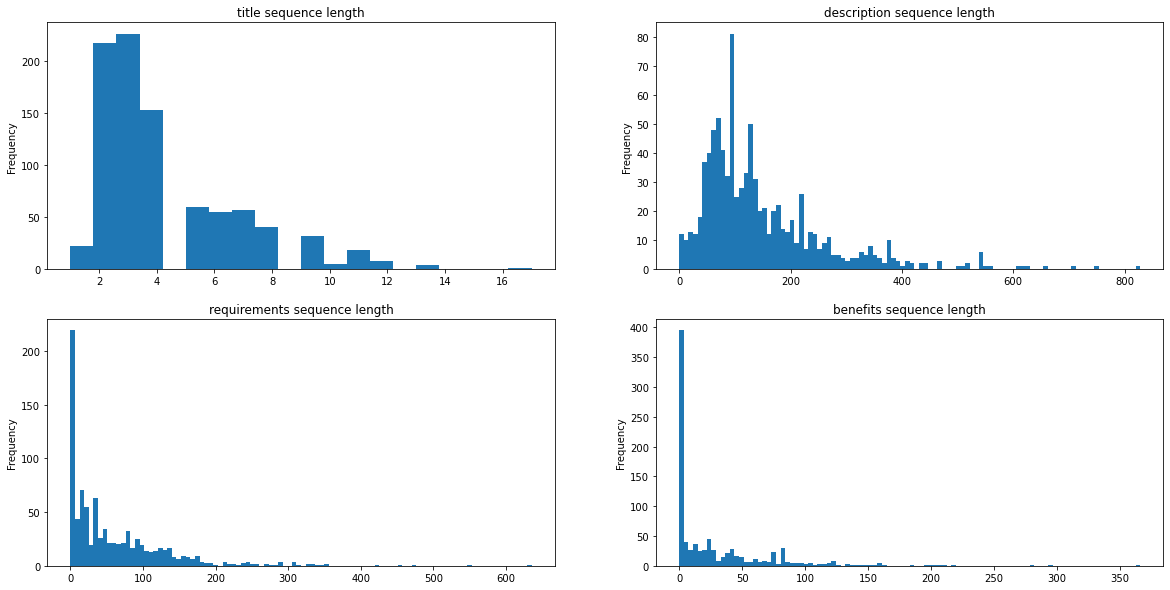

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
display_seq_hist(title_seq, bins=20, title='title sequence length', xlabel="length", ylabel="hits" )
plt.subplot(2,2,2)
display_seq_hist(desc_seq, title='description sequence length', xlabel="length", ylabel="hits" )
plt.subplot(2,2,3)
display_seq_hist(req_seq, title='requirements sequence length', xlabel="length", ylabel="hits" )
plt.subplot(2,2,4)
display_seq_hist(benefit_seq, title='benefits sequence length', xlabel="length", ylabel="hits" )

In [7]:
# Use padding to make length same
# pad 0 from post, truncate from post

from keras.preprocessing.sequence import pad_sequences
title_seq_pad = pad_sequences(title_seq, maxlen=max([len(s) for s in title_seq]), padding='post', truncating='post')
desc_seq_pad = pad_sequences(desc_seq, maxlen=max([len(s) for s in desc_seq]), padding='post', truncating='post')
req_seq_pad = pad_sequences(req_seq, maxlen=max([len(s) for s in req_seq]), padding='post', truncating='post')
benefit_seq_pad = pad_sequences(benefit_seq, maxlen=max([len(s) for s in benefit_seq]), padding='post', truncating='post')

In [8]:
country_index_map = {val: i for i, val in enumerate(df['country'].apply(lambda x: str(x)).unique())}
employment_type_index_map = {val: i for i, val in enumerate(df['employment_type'].apply(lambda x: str(x)).unique())}
required_experience_index_map = {val: i for i, val in enumerate(df['required_experience'].apply(lambda x: str(x)).unique())}
industry_index_map = {val: i for i, val in enumerate(df['industry'].apply(lambda x: str(x)).unique())}

In [9]:
# Using categorial and numerical data to train and classify whether a recruitment ad is scam or not 

# Making a comprehensive dataset to 
from math import ceil
input_shape = (
    df.shape[0],
    5,
    ceil(max([len(country_index_map), len(employment_type_index_map), len(industry_index_map), len(required_experience_index_map)]) / 10) * 10
)
comprehensive_dataset = np.zeros(input_shape, dtype=np.float32) #define empty dataset

for row_index, is_fraudulent in enumerate(df['fraudulent'].values):
    token_index = 0
    comprehensive_dataset[row_index, token_index, 0] = 1 if df['telecommuting'].values[row_index] else 0
    comprehensive_dataset[row_index, token_index, 1] = 1 if df['has_company_logo'].values[row_index] else 0
    comprehensive_dataset[row_index, token_index, 2] = 1 if df['has_questions'].values[row_index] else 0

    comprehensive_dataset[row_index, token_index, 4] = df['title_caps'].values[row_index]

    comprehensive_dataset[row_index, token_index, 5] = df['description_bul_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 6] = df['company_profile_bul_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 7] = df['requirements_bul_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 8] = df['benefits_bul_cnt_norm'].values[row_index]

    comprehensive_dataset[row_index, token_index, 9] = df['description_par_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 10] = df['company_profile_par_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 11] = df['requirements_par_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 12] = df['benefits_par_cnt_norm'].values[row_index]

    comprehensive_dataset[row_index, token_index, 13] = df['description_bold_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 14] = df['company_profile_bold_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 15] = df['requirements_bold_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 16] = df['benefits_bold_cnt_norm'].values[row_index]

    comprehensive_dataset[row_index, token_index, 17] = df['description_url_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 18] = df['company_profile_url_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 19] = df['requirements_url_cnt_norm'].values[row_index]
    comprehensive_dataset[row_index, token_index, 20] = df['benefits_bold_url_norm'].values[row_index]
    token_index += 1

    comprehensive_dataset[row_index, token_index, country_index_map[str(df['country'].values[row_index])]] = 1
    token_index += 1

    comprehensive_dataset[row_index, token_index, employment_type_index_map[str(df['employment_type'].values[row_index])]] = 1
    token_index += 1

    comprehensive_dataset[row_index, token_index, required_experience_index_map[str(df['required_experience'].values[row_index])]] = 1
    token_index += 1

    comprehensive_dataset[row_index, token_index, industry_index_map[str(df['industry'].values[row_index])]] = 1

In [10]:
# Making Y_labels if fradulent = 1 else 0

labels = np.array(df['fraudulent'].apply(lambda x: 1 if x == 't' else 0).values)

In [11]:
# Create a MLP model
from keras import Sequential, Input
from keras.layers import Dense, Reshape
mlp_model = Sequential()
mlp_model.add(Input(shape=(input_shape[1], input_shape[2])))
mlp_model.add(Reshape((input_shape[1] * input_shape[2],), input_shape=(input_shape[1], input_shape[2])))
mlp_model.add(Dense(10, activation='relu'))   # Hidden layer 1
mlp_model.add(Dense(int(input_shape[2] / 10), activation='relu'))   # Hidden layer 2
mlp_model.add(Dense(1, activation='sigmoid'))   # Output layer
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])   # define loss function and optimizer

other_score = mlp_model.predict(comprehensive_dataset)

In [12]:
# Define function for plotting graphs
def history_visualize(history):
    def plot_single(ax, history, term):
        ax.plot(history.history[term])
        ax.plot(history.history[f'val_{term}'])
        ax.set_xlabel("epochs")
        ax.set_ylabel(term)
        ax.set_ylim([0,1])
        ax.legend([term, f'val_{term}'])
    _, ax = plt.subplots(ncols=2, figsize=(16,8))
    plot_single(ax[0], history, 'loss')
    plot_single(ax[1], history,'accuracy')

In [13]:
# Train and evaluate a MLP model using comprehensive_dataset as input data
from sklearn.model_selection import train_test_split, KFold

# 5-fold
xtrain, xtest, ytrain, ytest = train_test_split(comprehensive_dataset, labels, test_size=0.2, random_state=1)

from keras import callbacks
es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
history = mlp_model.fit(xtrain, ytrain, epochs=1000, callbacks=[es_callback], validation_split=0.2, verbose=0)
mlp_test_acc = mlp_model.evaluate(xtest, ytest)[1]
print(f"Accuracy on test: {np.around(mlp_test_acc, 3)}")

6/6 [==============================] - 0s 5ms/step - loss: 0.3128 - accuracy: 0.8833
Accuracy on test: 0.883


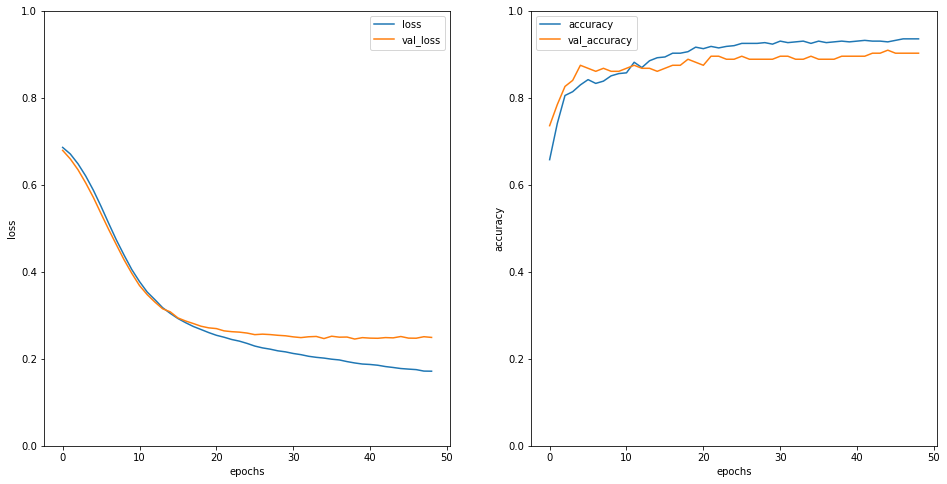

In [14]:
history_visualize(history)

In [15]:
# Define NLP model 

def train_nlp_seq_model(seq, labels, vocab_size, num_epochs, random_state):
    max_length = len(seq[0])
    embedding_dim = 16

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), # embedding 
        tf.keras.layers.GlobalAveragePooling1D(), # using average pooling layer 
        tf.keras.layers.Dense(24, activation='relu'), # hidden layer with 24 nodes
        tf.keras.layers.Dense(1, activation='sigmoid') # output layer
    ])
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    xtrain, xtest, ytrain, ytest = train_test_split(seq, labels, test_size=0.2, random_state=random_state)

    es_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    history = model.fit(xtrain, ytrain, epochs=num_epochs, callbacks=[es_callback], validation_split=0.2, verbose=0)
    test_acc = model.evaluate(xtest, ytest)[1]
    print(f"Accuracy on test: {test_acc}")
    
    return history, model, test_acc

6/6 [==============================] - 0s 1ms/step - loss: 0.3687 - accuracy: 0.8333
Accuracy on test: 0.8333333134651184


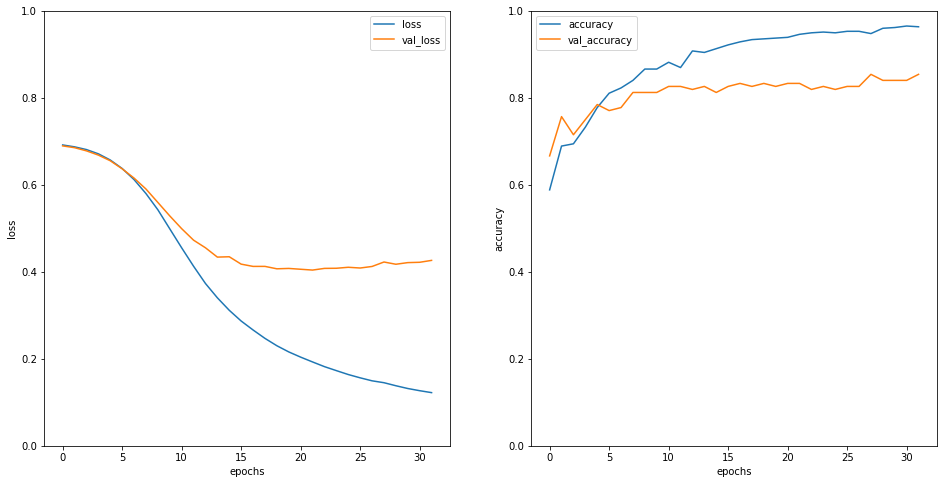

In [16]:
# Train and evaluate a NLP model using tokenized "Title" data
title_network_history, title_network, title_test_acc = train_nlp_seq_model(title_seq_pad, labels, DEFAULT_VOCAB_SIZE, 1000, 1)
title_score = title_network.predict(title_seq_pad)
history_visualize(title_network_history)

6/6 [==============================] - 0s 4ms/step - loss: 0.3614 - accuracy: 0.8722
Accuracy on test: 0.8722222447395325


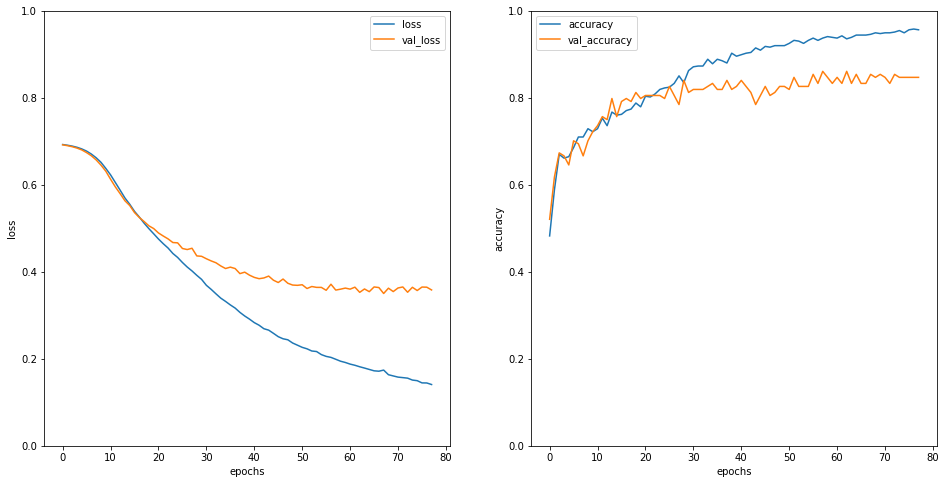

In [17]:
# Train and evaluate a NLP model using tokenized "Description" data
desc_network_history, desc_network, desc_test_acc = train_nlp_seq_model(desc_seq_pad, labels, DEFAULT_VOCAB_SIZE, 1000, 1)
desc_score = desc_network.predict(desc_seq_pad)

history_visualize(desc_network_history)

6/6 [==============================] - 0s 2ms/step - loss: 0.6094 - accuracy: 0.7778
Accuracy on test: 0.7777777910232544


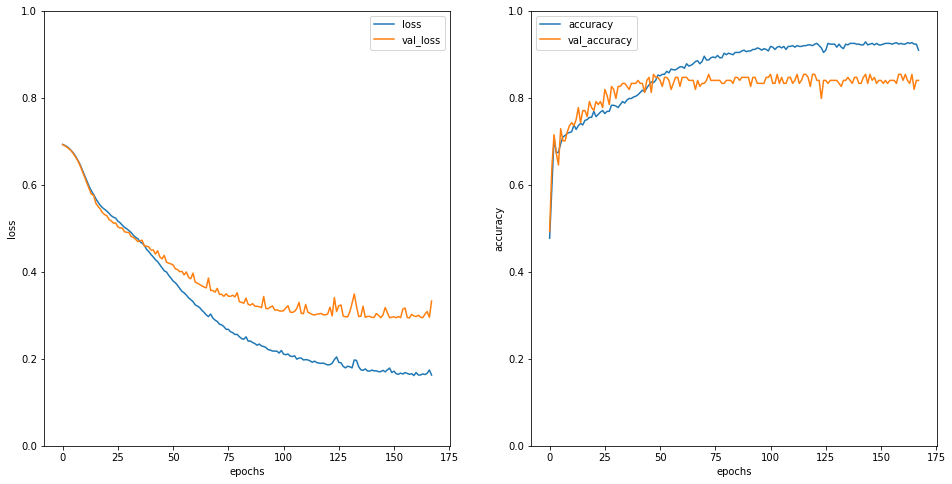

In [18]:
# Train and evaluate a NLP model using tokenized "Requirements" data
req_network_history, req_network, req_test_acc = train_nlp_seq_model(req_seq_pad, labels, DEFAULT_VOCAB_SIZE, 1000, 1)
req_score = req_network.predict(req_seq_pad)

history_visualize(req_network_history)

6/6 [==============================] - 0s 2ms/step - loss: 0.5094 - accuracy: 0.7667
Accuracy on test: 0.7666666507720947


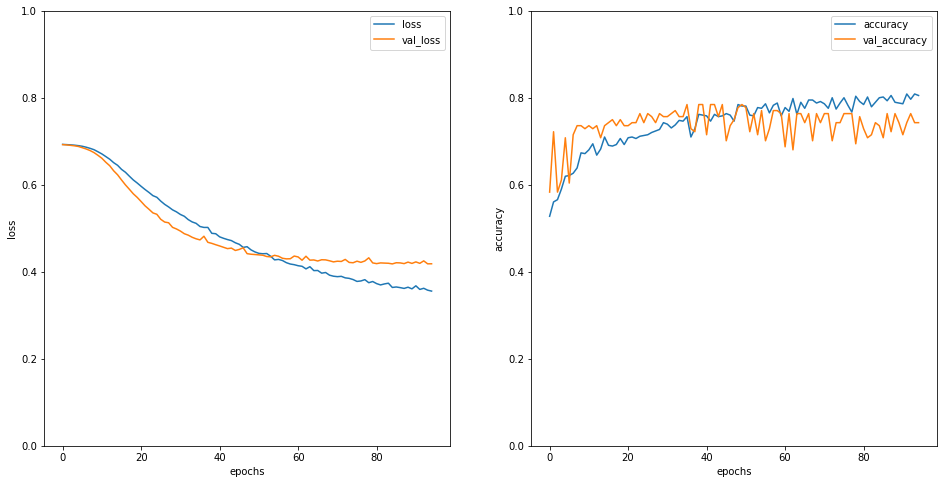

In [19]:
# Train and evaluate a NLP model using tokenized "Benefits" data
benefit_network_history, benefit_network,benefit_test_acc = train_nlp_seq_model(benefit_seq_pad, labels, DEFAULT_VOCAB_SIZE, 1000, 1)
benefit_score = benefit_network.predict(benefit_seq_pad)

history_visualize(benefit_network_history)

In [20]:
# ROC curve for Logistics Regression

from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

def roc (model, x_tests, y_tests, name):
    probs_y = model.predict_proba(x_tests)

    fprs, tprs, thresholds = roc_curve(y_tests, probs_y[:, 1])

    sns.lineplot(x=fprs, y=tprs, label='ROC')
    sns.lineplot(x=[0, 1], y=[0, 1], color='red', label='Random')

    plt.title("ROC Curve on {0}".format(name))
    plt.xlabel('FPR');
    plt.ylabel('TPR(Recall)')
    plt.grid()
    plt.legend()
    plt.show()

    auc = roc_auc_score(y_test, probs_y[:,1])
    print(f"The AUC score for {name}: {auc}")

C:\Users\awzhe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test dataset: 0.6


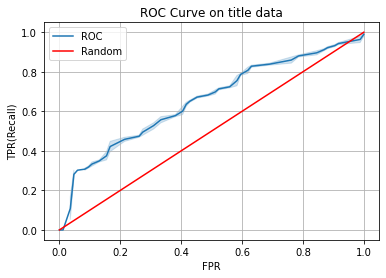

The AUC score for title data: 0.6536458333333333


In [21]:
# Implementation of Logistics Regression
# Train and evaluate LR model using "Title" as input data 
from sklearn.linear_model import LogisticRegression as lr

X_train, X_test, y_train, y_test = train_test_split(title_seq_pad, labels, test_size=0.2, random_state=1)
LR_title = lr(max_iter=100)
LR_title.fit(X_train, y_train)
LR_title_acc = LR_title.score(X_test, y_test)
LR_title_pred = LR_title.predict(title_seq_pad)
print("Accuracy on test dataset: " + str(LR_title_acc))
roc(LR_title,X_test,y_test, "title data")

Accuracy on test dataset: 0.6555555555555556


C:\Users\awzhe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


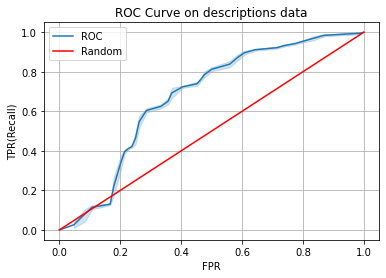

The AUC score for descriptions data: 0.6752232142857142


In [22]:
# Train and evaluate LR model using "Descriptions" as input data 

X_train, X_test, y_train, y_test = train_test_split(desc_seq_pad, labels, test_size=0.2, random_state=1)
LR_desc = lr(max_iter=100)
LR_desc.fit(X_train, y_train)
LR_desc_acc = LR_desc.score(X_test, y_test)
LR_desc_pred = LR_desc.predict(desc_seq_pad)
print("Accuracy on test dataset: " + str(LR_desc_acc))
roc(LR_desc,X_test,y_test, "descriptions data")

Accuracy on test dataset: 0.6944444444444444


C:\Users\awzhe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


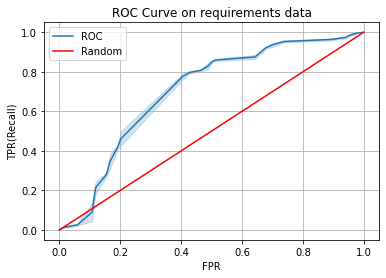

The AUC score for requirements data: 0.7016369047619048


In [23]:
# Train and evaluate LR model using "Requirements" as input data 

X_train, X_test, y_train, y_test = train_test_split(req_seq_pad, labels, test_size=0.2, random_state=1)
LR_req = lr(max_iter=100)
LR_req.fit(X_train, y_train)
LR_req_acc = LR_req.score(X_test, y_test)
LR_req_pred = LR_req.predict(req_seq_pad)
print("Accuracy on test dataset: " + str(LR_req_acc))
roc(LR_req,X_test,y_test, "requirements data")

Accuracy on test dataset: 0.6444444444444445


C:\Users\awzhe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


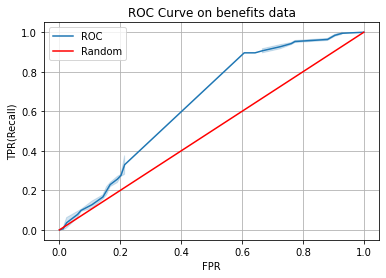

The AUC score for benefits data: 0.6529017857142858


In [24]:
# Train and evaluate LR model using "Benefits" as input data 

X_train, X_test, y_train, y_test = train_test_split(benefit_seq_pad, labels, test_size=0.2, random_state=1)
LR_benefit = lr(max_iter=100)
LR_benefit.fit(X_train, y_train)
LR_benefit_acc = LR_benefit.score(X_test, y_test)
LR_benefit_pred = LR_benefit.predict(benefit_seq_pad)
print("Accuracy on test dataset: " + str(LR_benefit_acc))
roc(LR_benefit,X_test,y_test, "benefits data")

In [25]:
#ROC curve for SVM
class roc_curves:
    def __init__ (self, X_trains, y_trains, best_parameter):
        self.temp_model = SVC(C=best_parameter["C"], gamma=best_parameter["gamma"], random_state = 1, probability = True).fit(X_trains, y_trains)
        
    def roc_curve_draw(self,x_tests, y_tests, name):
        threshold =[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5,
                    0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
        TPR_list =[]
        FPR_list =[]

        y_pred_prob = self.temp_model.predict_proba(x_tests)

        for i in threshold:
            y_pred = (y_pred_prob[:,1] >= i).astype(int)

            TP = 0
            FN = 0
            TN = 0
            FP = 0
            for i,j in zip(y_pred, y_tests):
                if i == j and i == 1:
                    TP += 1
                elif i != j and i == 0:
                    FN += 1
                elif i != j and i == 1:
                    FP += 1
                else:
                    TN += 1

            TPR = TP/(TP+FN)
            TPR_list.append(TPR)

            FPR = FP/(TN+FP)
            FPR_list.append(FPR)
        

        plt.figure()
        plt.title("ROC Curve on {0}".format(name))
        plt.plot(FPR_list,TPR_list, label='ROC curve')
        plt.plot([0,1],[0,1], linestyle='--', label="random")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()
        auc = roc_auc_score(y_tests, y_pred_prob[:,1])
        return auc

The accuracy of test data is 0.7611111111111111
The best parameters are {'C': 1000, 'gamma': 0.0001}


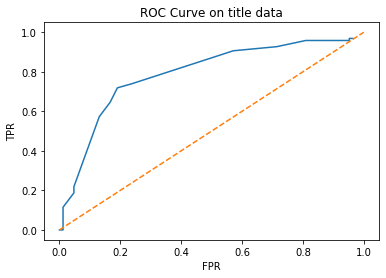

The AUC score for title data: 0.7962549603174603


In [26]:
# Implementation of Support Vector Machine
# Train and evaluate SVM model using "Title" as input data 
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(title_seq_pad, labels, test_size=0.2, random_state=1)


# Choose the best hyperparameter and calculate the accuracy

best_score = 0
best_params = {'C':None, 'gamma':None}  

for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        temp_model = SVC(C=C, gamma=gamma, random_state = 1).fit(X_train, y_train)
        score = temp_model.score(X_test, y_test)
        
        if score > best_score :
            best_score = score
            best_params = {"C":C, 'gamma': gamma}
            
            
SVM_title_acc = best_score
SVM_title_pred = temp_model.predict(title_seq_pad)
print('The accuracy of test data is', best_score)
print('The best parameters are', best_params)

roc = roc_curves(X_train,y_train,best_params)    
auc_title = roc.roc_curve_draw(X_test,y_test,"title data")
print("The AUC score for title data:", auc_title)

The accuracy of test data is 0.7
The best parameters are {'C': 1, 'gamma': 0.0001}


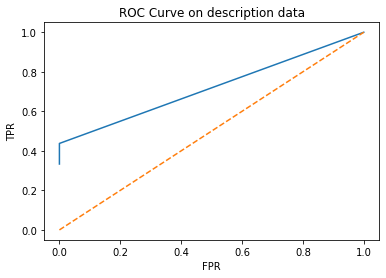

the AUC score for description data: 0.71875


In [27]:
# Train and evaluate SVM model using "Description" as input data 

X_train, X_test, y_train, y_test = train_test_split(desc_seq_pad, labels, test_size=0.2, random_state=1)


# Choose the best hyperparameter and calculate the accuracy

best_score = 0
best_params = {'C':None, 'gamma':None}  

for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        temp_model = SVC(C=C, gamma=gamma, random_state = 1).fit(X_train, y_train)
        score = temp_model.score(X_test, y_test)
        
        if score > best_score :
            best_score = score
            best_params = {"C":C, 'gamma': gamma}
            
            
SVM_desc_acc = best_score
SVM_desc_pred = temp_model.predict(desc_seq_pad)
print('The accuracy of test data is', best_score)
print('The best parameters are', best_params)

roc = roc_curves(X_train,y_train,best_params)    
auc_desc = roc.roc_curve_draw(X_test,y_test,"description data")
print("the AUC score for description data:", auc_desc)

The accuracy of test data is 0.7
The best parameters are {'C': 1, 'gamma': 0.0001}


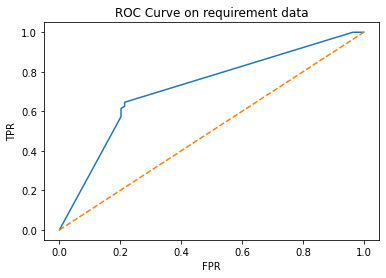

the AUC score for requirement data: 0.7204241071428571


In [28]:
# Train and evaluate SVM model using "Requirements" as input data 

X_train, X_test, y_train, y_test = train_test_split(req_seq_pad, labels, test_size=0.2, random_state=1)


# Choose the best hyperparameter and calculate the accuracy

best_score = 0
best_params = {'C':None, 'gamma':None}  

for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        temp_model = SVC(C=C, gamma=gamma, random_state = 1).fit(X_train, y_train)
        score = temp_model.score(X_test, y_test)
        
        if score > best_score :
            best_score = score
            best_params = {"C":C, 'gamma': gamma}
            
            
SVM_req_acc = best_score
SVM_req_pred = temp_model.predict(req_seq_pad)
print('The accuracy of test data is', best_score)
print('The best parameters are', best_params)

roc = roc_curves(X_train,y_train,best_params)    
auc_req = roc.roc_curve_draw(X_test,y_test,"requirement data")
print("the AUC score for requirement data:", auc_req)

The accuracy of test data is 0.7
The best parameters are {'C': 10, 'gamma': 0.0001}


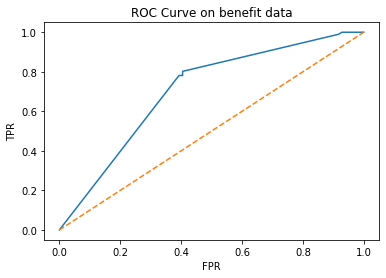

the AUC score for title data: 0.6753472222222222


In [29]:
# Train and evaluate SVM model using "Benefit" as input data 

X_train, X_test, y_train, y_test = train_test_split(benefit_seq_pad, labels, test_size=0.2, random_state=1)


# Choose the best hyperparameter and calculate the accuracy

best_score = 0
best_params = {'C':None, 'gamma':None}  

for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    for C in [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        temp_model = SVC(C=C, gamma=gamma, random_state = 1).fit(X_train, y_train)
        score = temp_model.score(X_test, y_test)
        
        if score > best_score :
            best_score = score
            best_params = {"C":C, 'gamma': gamma}
            
            
SVM_benefit_acc = best_score
SVM_benefit_pred = temp_model.predict(benefit_seq_pad)
print('The accuracy of test data is', best_score)
print('The best parameters are', best_params)

roc = roc_curves(X_train,y_train,best_params)    
auc_benefit = roc.roc_curve_draw(X_test,y_test,"benefit data")
print("the AUC score for title data:", auc_benefit)

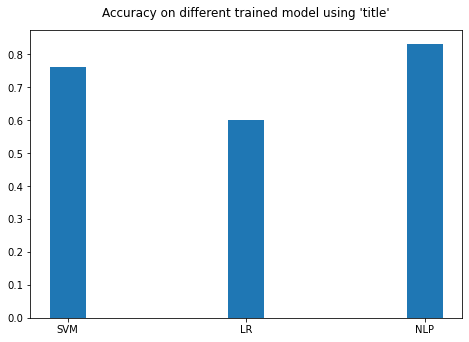

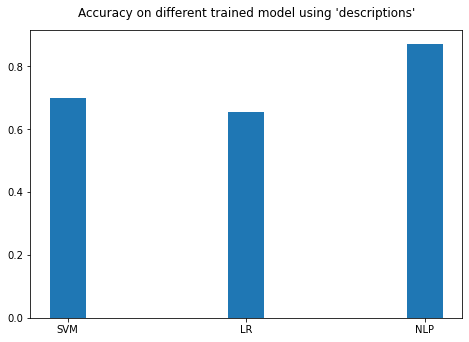

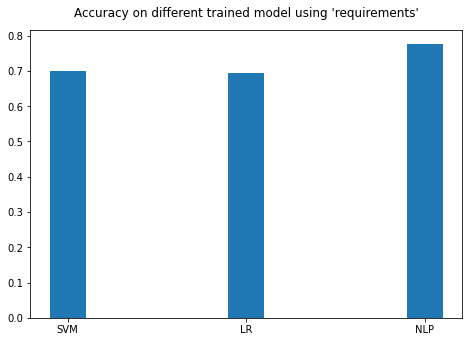

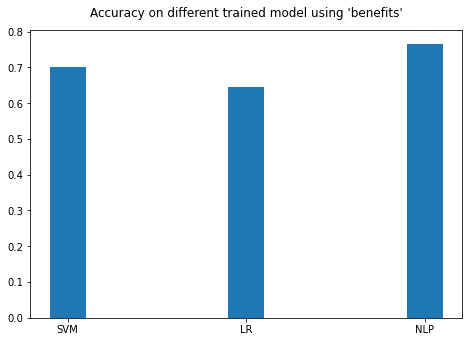

In [30]:
#accuracy comparison
SVM_list = [SVM_title_acc,SVM_desc_acc, SVM_req_acc, SVM_benefit_acc]
LRE_list = [LR_title_acc, LR_desc_acc, LR_req_acc, LR_benefit_acc]
NLP_list = [title_test_acc,desc_test_acc,req_test_acc,benefit_test_acc]
title = ["title", "descriptions", "requirements", "benefits"]

for i in range (len(title)):
    fig = plt.figure()
    fig.suptitle("Accuracy on different trained model using '{0}'".format(title[i]))
    ax = fig.add_axes([0,-0.1,1,1])
    models = ['SVM', 'LR', 'NLP']
    models_acc = [SVM_list[i], LRE_list[i], NLP_list[i]]
    ax.bar(models, models_acc, 0.2)
plt.show()

In [31]:
# Combine information about title, description, requirement, benefit, others(comprehensive_dataset)
# Combination of prediction generated by 4 NLP and 1 MLP model
# Use this information as input to train a neural network and classify whether it is fraudulent or not

input_data = np.zeros((len(title_score), 5), dtype='float32')
for i, _ in enumerate(title_score):
    input_data[i, 0] = title_score[i][0]
    input_data[i, 1] = desc_score[i][0]
    input_data[i, 2] = req_score[i][0]
    input_data[i, 3] = benefit_score[i][0]
    input_data[i, 4] = other_score[i][0]

Accuracy on test dataset: 0.8722222447395325


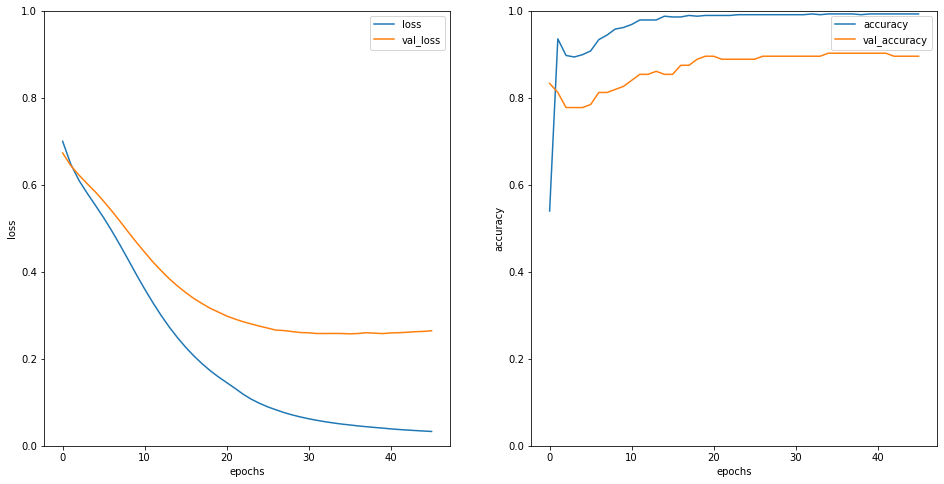

In [32]:
# Train and evaluate a Multi-Layer Neural Network using information from 4 NLP and 1 MLP model

comb_model = tf.keras.Sequential([
    tf.keras.Input(shape=(5,)),
    tf.keras.layers.Dense(24, activation='relu'), # 24 nodes hidden layer 
    tf.keras.layers.Dense(1, activation='sigmoid') # output layer, which is binary classification
])

comb_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(input_data, labels, test_size = 0.2, random_state = 1)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
history_1 = comb_model.fit(X_train, y_train, epochs=1000, callbacks=[callback], validation_split=0.2, verbose=0)

print("Accuracy on test dataset: " + str(comb_model.evaluate(X_test, y_test, verbose=0)[1]))
history_visualize(history_1)

In [33]:
# Get prediction generated by 4 NLP model which respectively uses "title", "description", "requirements", "benefit" as input data

input_data1 = np.zeros((len(title_score), 4), dtype='float32')
for i, _ in enumerate(title_score):
    input_data1[i, 0] = title_score[i][0]
    input_data1[i, 1] = desc_score[i][0]
    input_data1[i, 2] = req_score[i][0]
    input_data1[i, 3] = benefit_score[i][0]

Accuracy on test dataset: 0.8722222447395325


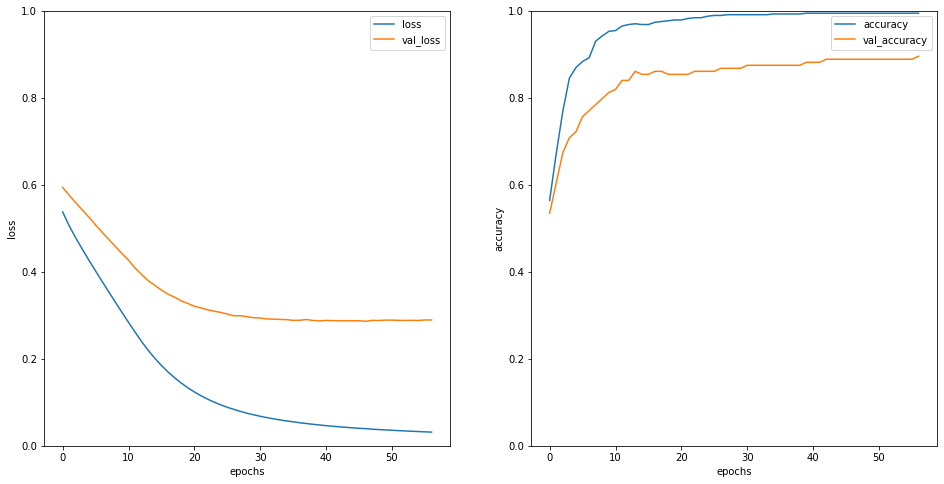

In [34]:
# Train and evaluate a Multi-Layer Neural Network using information from 4 NLP
comb_model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(4,)),
    tf.keras.layers.Dense(24, activation='relu'), # 24 nodes hidden layer 
    tf.keras.layers.Dense(1, activation='sigmoid') # output layer, which is binary classification
])

comb_model_1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(input_data1, labels, test_size = 0.2, random_state = 1)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
history_2 = comb_model_1.fit(X_train, y_train, epochs=1000, callbacks=[callback], validation_split=0.2, verbose=0)

print("Accuracy on test dataset: " + str(comb_model_1.evaluate(X_test, y_test, verbose=0)[1]))
history_visualize(history_2)

In [35]:
# Get prediction generated by LR models

LRE_input_data = np.zeros((len(LR_title_pred), 4), dtype='float32')
for i, _ in enumerate(LR_title_pred):
    LRE_input_data[i, 0] = LR_title_pred[i]
    LRE_input_data[i, 1] = LR_desc_pred[i]
    LRE_input_data[i, 2] = LR_req_pred[i]
    LRE_input_data[i, 3] = LR_benefit_pred[i]

In [36]:
# Get prediction generated by each SVM models

SVME_input_data = np.zeros((len(SVM_title_pred), 4), dtype='float32')
for i, _ in enumerate(SVM_title_pred):
    SVME_input_data[i, 0] = SVM_title_pred[i]
    SVME_input_data[i, 1] = SVM_desc_pred[i]
    SVME_input_data[i, 2] = SVM_req_pred[i]
    SVME_input_data[i, 3] = SVM_benefit_pred[i]

In [37]:
# Create a class to store accuracy to be used as weights
class StoreWeights:
    
    def __init__(self):
        self.list = []
    
    def store(self, weights):
        self.list.append(weights)
        
    def give_array(self):
        return np.array([self.list])

In [38]:
# Create an Ensemble Classifier which collect informations from the predictions of weak models and generate a new prediction
class EnsembleClassifier:
    
    def predict(self, input_data, model_weight):
        y_pred = []
        X = np.round(input_data)
        X = np.where(X == 0, -1, X)
        w = model_weight
        
        i = 0
        while i < input_data.shape[0]:
            prediction = 0
            
            j = 0
            while j < w.shape[1]:
                prediction += X[i][j]*w[0][j]
                j += 1
                
            y_pred.append(prediction)
            i += 1
        return np.sign(y_pred)
    
    def accuracy(self, predictions, labels):
        y_pred = predictions
        y_true = np.where(labels == 0, -1, labels)
    
        accuracy = np.sum(y_pred == y_true)/np.count_nonzero(y_pred)
        return accuracy

In [39]:
kf = KFold(n_splits=10)
# Ensemble learning using 4 NLP network and 1 MLP network
network_acc = StoreWeights()
network_acc.store(title_test_acc)
network_acc.store(desc_test_acc)
network_acc.store(req_test_acc)
network_acc.store(benefit_test_acc)
network_acc.store(mlp_test_acc)
network_weights = network_acc.give_array()

network_ensem = EnsembleClassifier()
NE_accuracy = []
for train_index, test_index in kf.split(labels):
    X_train, X_test = input_data[train_index], input_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    NE_y_pred = network_ensem.predict(X_test, network_weights)
    NE_accuracy.append(network_ensem.accuracy(NE_y_pred, y_test))
    
NE_avg_acc = np.around(np.mean(NE_accuracy), 3)
NE_std_acc = np.around(np.std(NE_accuracy), 3)
print(f"The average accuracy of the Ensemble Classifier using 4 NLP and 1 MLP network is: {NE_avg_acc} ({NE_std_acc})")

The average accuracy of the Ensemble Classifier using 4 NLP and 1 MLP network is: 0.92 (0.048)


In [40]:
# Ensemble learning using 4 NLP network
network2_acc = StoreWeights()
network2_acc.store(title_test_acc)
network2_acc.store(desc_test_acc)
network2_acc.store(req_test_acc)
network2_acc.store(benefit_test_acc)
network2_weights = network2_acc.give_array()

network2_ensem = EnsembleClassifier()
NE2_accuracy = []
for train_index, test_index in kf.split(labels):
    X_train, X_test = input_data1[train_index], input_data1[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    NE2_y_pred = network2_ensem.predict(X_test, network2_weights)
    NE2_accuracy.append(network2_ensem.accuracy(NE2_y_pred, y_test))
    
NE2_avg_acc = np.around(np.mean(NE2_accuracy), 3)
NE2_std_acc = np.around(np.std(NE2_accuracy), 3)
print(f"The average accuracy of the Ensemble Classifier using 4 NLP network is: {NE2_avg_acc} ({NE2_std_acc})")

The average accuracy of the Ensemble Classifier using 4 NLP network is: 0.944 (0.025)


In [41]:
# Ensemble learning using 4 Logistic Regression models
LR_acc = StoreWeights()
LR_acc.store(LR_title_acc)
LR_acc.store(LR_desc_acc)
LR_acc.store(LR_req_acc)
LR_acc.store(LR_benefit_acc)
LR_weights = LR_acc.give_array()   

LR_ensem = EnsembleClassifier()
LRE_accuracy = []
for train_index, test_index in kf.split(labels):
    X_train, X_test = LRE_input_data[train_index], LRE_input_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    LRE_y_pred = LR_ensem.predict(X_test, LR_weights)
    LRE_accuracy.append(LR_ensem.accuracy(LRE_y_pred, y_test))

LRE_avg_acc = np.around(np.mean(LRE_accuracy), 3)
LRE_std_acc = np.around(np.std(LRE_accuracy), 3)
print(f"The accuracy of the Ensemble Classifier using 4 Logistics Regression model is: {LRE_avg_acc} ({LRE_std_acc})")

The accuracy of the Ensemble Classifier using 4 Logistics Regression model is: 0.84 (0.082)


In [42]:
# Ensemble learning using 4 SVM models
SVM_acc = StoreWeights()
SVM_acc.store(SVM_title_acc)
SVM_acc.store(SVM_desc_acc)
SVM_acc.store(SVM_req_acc)
SVM_acc.store(SVM_benefit_acc)
SVM_weights = SVM_acc.give_array()

SVM_ensem = EnsembleClassifier()
SVME_accuracy = []
for train_index, test_index in kf.split(labels):
    X_train, X_test = SVME_input_data[train_index], SVME_input_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    SVME_y_pred = SVM_ensem.predict(X_test, SVM_weights)
    SVME_accuracy.append(SVM_ensem.accuracy(SVME_y_pred, y_test))
    
SVME_avg_acc = np.around(np.mean(SVME_accuracy), 3)
SVME_std_acc = np.around(np.std(SVME_accuracy), 3)
print(f"The accuracy of the Ensemble Classifier using 4 SVM models is: {SVME_avg_acc} ({SVME_std_acc})")

The accuracy of the Ensemble Classifier using 4 SVM models is: 0.942 (0.056)


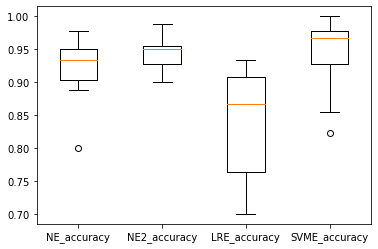

In [43]:
#Comparsion graphs
#accuracy comparison on ensemble model
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(x=(NE_accuracy, NE2_accuracy, LRE_accuracy, SVME_accuracy))
ax.set_xticklabels(("NE_accuracy","NE2_accuracy", "LRE_accuracy", "SVME_accuracy"))
plt.show()